# 1950's and 1960's Science Fiction
### Unit 4 - NLP Capstone

Just after the Golden Age of science fiction from 1938-1946, science fiction literature in the 1950's and early 1960's continued to be published in magazines. This is an analysis of 1950s and 1960s science fiction stories from Project Gutenberg. The stories are from several different science fiction magazines.  32 different works by 10 different authors were used in the analysis. 2-4 works per author were selected. Each short story was split into several sections.  They were split at the thought breaks, marked either by five astericks (*) or several hyphens (————) in the story.  

The objective of this analysis is to see if after training the dataset on some of the thought breaks, can I predict the author and potentially the work of the thought breaks that have not yet been seen. In addition, which works are similar to each other?  If I cluster the works, with unsupervised clustering, are they clustered primarily by author, or can I find a different criteria by which they are clustered.  There are several common tropes, or themes in science fiction and perhaps they will cluster by those.


### Data Sources
https://www.gutenberg.org/ <br>
1. Second Variety, Philip Dick, https://www.gutenberg.org/ebooks/32032, Space Science Fiction, May 1953, dick1.txt 
2. The Hanging Stranger, Philip Dick, https://www.gutenberg.org/ebooks/41562, Science Fiction Adventures, December 1953, dick2.txt
3. The Spicy Sound of Success, Jim Harmon, https://www.gutenberg.org/ebooks/51351, Galaxy Magazine, August 1959, harmon1.txt
4. Confidence Game, Jim Harmon, https://www.gutenberg.org/ebooks/51305, Galaxy Science Fiction, June 1957, harmon2.txt 
5. Break a Leg, Jim Harmon, https://www.gutenberg.org/ebooks/51320, Galaxy Science Fiction, November 1957, harmon3.txt 
6. A Hitch in Space, Fritz Leiber, https://www.gutenberg.org/ebooks/53042, Worlds of Tomorrow August 1963, leiber1.txt
7. A Pail of Air, Fritz Leiber, https://www.gutenberg.org/ebooks/51461, Galaxy Science Fiction Dec 1951, leiber2.txt
8. Coming Attraction, Fritz Leiber, https://www.gutenberg.org/ebooks/51082, Galaxy Science Fiction, November 1950, leiber3.txt
9. A Bad Day for Sales, Fritz Leiber, https://www.gutenberg.org/ebooks/50819, Galaxy Science Fiction, July 1953, leiber4.txt
10. Doctor, Murray Leinster, https://www.gutenberg.org/ebooks/51782, Galaxy Science Fiction, February 1961, leinster1.txt
11. If You Was a MOKLIN, Murray Leinster, https://www.gutenberg.org/ebooks/51752, Galaxy Science Fiction, September 1951, leinster2.txt
12. Med Ship Man, Murray Leinster, https://www.gutenberg.org/ebooks/50999, Galaxy Science Fiction, October 1963, leinster3.txt
13. Third Planet, Murray Leinster, https://www.gutenberg.org/ebooks/52574, Worlds of Tomorrow, April 1963, leinster4.txt
14. To Save Earth, Edward Ludwig, https://www.gutenberg.org/ebooks/53059, Worlds of Tomorrow, October 1963, ludwig1.txt
15. Spacemen Die at Home, Edward Ludwig, https://www.gutenberg.org/ebooks/51249, Galaxy Science Fiction, October 1951, ludwig2.txt
16. The Lonely Ones, Edward Ludwig, https://www.gutenberg.org/ebooks/38302, Galaxy Science Fiction, July 1953, ludwig3.txt
17. A Coffin for Jacob, Edward Ludwig, https://www.gutenberg.org/ebooks/51203, Galaxy Science Fiction, May 1956, ludwig4.txt
18. $1,000 A Plate, Jack McKenty, https://www.gutenberg.org/ebooks/50921, Galaxy Science Fiction, October 1954, mckenty1.txt
19. Wait for Weight, Jack McKenty, https://www.gutenberg.org/ebooks/32717, Galaxy Science Fiction, October 1952, mckenty2.txt
20. The Tunnel Under the World, Frederik Pohl, https://www.gutenberg.org/ebooks/31979, Galaxy Science Fiction, January 1955, pohl1.txt
21. Plague of Pythons, Frederik Pohl, https://www.gutenberg.org/ebooks/51804, Galaxy Science Fiction, October and December 1962, pohl2.txt
22. Survival Kit, Frederik Pohl, https://www.gutenberg.org/ebooks/51809, Galaxy Science Fiction, May 1957, pohl3.txt
23. Sea Legs, Frank Quattrocchi, https://www.gutenberg.org/ebooks/51407, Galaxy Science Fiction, November 1951, quattrochi1.txt
24. The Sword, Frank Quattrocchi, https://www.gutenberg.org/ebooks/32697, IF Worlds of Science Fiction, March 1953, quattrochi2.txt
25. Spaceman on a Spree, Mack Reynolds, https://www.gutenberg.org/ebooks/52995, Worlds of Tomorrow, June 1963, reynolds1.txt
26. Potential Enemy, Mack Reynolds, https://www.gutenberg.org/ebooks/40954, Orbit volume 1
number 2, 1953, reynolds2.txt
27. Farmer, Mack Reynolds, https://www.gutenberg.org/ebooks/51799, Galaxy Science Fiction, June 1961, reynolds3.txt
28. Unborn Tomorrow, Mack Reynolds, https://www.gutenberg.org/ebooks/23942, Astounding Science Fiction, June 1959, reynods4.txt
29. When You Giffle, L.J. Stecher Jr., https://www.gutenberg.org/ebooks/53035, Worlds of Tomorrow, December 1963, stecher1.txt
30. An Elephant for the Prinkip, L.J. Stecher Jr., https://www.gutenberg.org/ebooks/51434, Galaxy Science Fiction, August 1960, stecher2.txt
31. Man in a Sewing Machine, L.J. Stecher Jr., https://www.gutenberg.org/ebooks/50936, Galaxy Science Fiction, February 1956, stecher3.txt
32. Perfect Answer, L.J. Stecher Jr., https://www.gutenberg.org/ebooks/51482, Galaxy Science Fiction, June 1958, stecher4.txt
<br>

### References:
Clustering KMeans Centroids:
https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py

Science Fiction History: 
https://en.wikipedia.org/wiki/Golden_Age_of_Science_Fiction



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

from nltk.corpus import stopwords
import spacy
from spacy.pipeline import SentenceSegmenter
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load('en')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer, normalize

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder

from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

## File Cleaning
Each file was downloaded as a text UTF-8 document.  The utility function used for cleaning the files can run a little slow because it is checking each file for a number of different header and footer options that need to be removed.  A different version of the file cleaner could have been written for each type of format, but I decided to sacrifice speed for ease of use and a more universal file cleaning function. In addition, they only need to be cleaned once as the files are written to a new folder that can then be used for the remaining project. 

The stories are split at thought breaks that are marked by either five astericks or hyphens.  These are usually several paragraphs long. 

In [2]:
# Utility function for standard text cleaning
def text_cleaner(text):
    
    # One version of story section separator, replace with @SentBoundary@
    # These are hyphens, not dashes.
    text = re.sub(r'————', ' @SentBoundary@ ', text )
    
    # Spacy does not recognize: the double dash '--'. 
    text = re.sub(r'--', ' ',text)
    
    # Spacy thinks underscores are a new sentence
    text = re.sub('_', ' ', text)
    
    # Remove text between brackets
    text = re.sub('[\[][\S\s]*?[\]]', "", text)
    
    # Remove beginning of file Project Gutenberg info
    text = re.sub('[\S\s]*(ILLUSTRATED BY .*)', '', text)
    
    # Different format for beginning
    text = re.sub('[\S\s]*(Illustrated by .*)', '', text)
      
    # Remove Project Gutenberg end of file info
    text = re.sub('End of (the )*Project Gutenberg[\S\s]*', '', text, 1)
    
    # Remove Project Gutenberg end of file info
    text = re.sub('_Transcriber\'s note_[\S\s]*', '', text, 1)
    
    # Remove Project Gutenberg end of file info, different format
    text = re.sub('TRANSCRIBER\'S NOTE[\S\s]*', '', text, 1)
    
    # One text ends with the author name
    text = re.sub('=JACK McKENTY=[\S\s]*', '', text, 1)
    
    # Remove story section separators, add uniform story section separator
    text = re.sub('(\s*\*){5}', ' @SentBoundary@ ', text)
    
    # No illustrators in these ones
    text = re.sub('[\S\s]*([Bb][Yy] L. J. STECHER, JR\.)', '', text, 1)
    text = re.sub('[\S\s]*(by Mack Reynolds)', '', text, 1)
    
    # Some texts end with END or THE END
    text = re.sub('\n(THE)* *(END)\n[\S\s]*', '', text, 1)
    
    # Some texts have roman numeral subdivisions, doesn't exceed III
    text = re.sub('\n[I]+\n', '\n\n', text)
    
    text = re.sub('[\n\r]', ' ', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

In [3]:
# This allows me to split on the custom line breaks @SentBoundary@
# This was written in during the cleaning stage.  I don't want this in my final
# Text, so it yields a doc including the parts before the break
# See https://github.com/explosion/spaCy/issues/2791 for more details
def split_on_breaks(doc):
    start = 0
    seen_break = False
    for word in doc:
        if seen_break:
            yield doc[start:word.i-1]
            start = word.i
            seen_break = False
        elif word.text == '@SentBoundary@':
            seen_break = True
    if start < len(doc):
        yield doc[start:len(doc)]

sbd = SentenceSegmenter(nlp.vocab, strategy=split_on_breaks)
nlp.add_pipe(sbd, first=True)


In [4]:
# This opens files and cleans them
def clean_files(path, path_clean, clean_file=True):

    if clean_file == False:
        path = path_clean

    filelist = os.listdir(path)
    sentences = []
    file_num = 0

    for x in filelist:
        if x.endswith('.txt'):
            # Can use this to debug, not currently used
            file_num += 1
            try:
                with open(path + x, 'r') as file:
                    text = file.read()
                    # Save a version of the cleaned files, this process takes a while
                    if clean_file == True:
                        text = text_cleaner(text)  
                        file_new = path_clean + x
                        with open(file_new, 'w') as file_cleaned:
                            file_cleaned.write(text)  

                    text_nlp = nlp(text)
                    # File naming convention was author + number, remove .txt and number
                    # to get author
                    text_sents = [[sent, x[:-4], x[:-5]] for sent in text_nlp.sents]
                    sentences += text_sents
                    print(x)
            except:
                print('Failed Text: {}'.format(x))
                pass
    
    return sentences

In [5]:
# This opens the files and cleans them.  It can take a while to run.

path = 'science_fiction/'
path_clean = 'science_fiction_cleaned/'

# Change this to False if the files have already been cleaned
clean_file = False

sentences = clean_files(path, path_clean, False)

dick2.txt
dick1.txt
quattrocchi1.txt
quattrocchi2.txt
mckenty1.txt
stecher3.txt
stecher2.txt
mckenty2.txt
stecher1.txt
stecher4.txt
pohl2.txt
pohl3.txt
leiber1.txt
leiber3.txt
pohl1.txt
leiber2.txt
harmon3.txt
harmon2.txt
harmon1.txt
leiber4.txt
leinster3.txt
reynolds4.txt
ludwig1.txt
leinster2.txt
ludwig3.txt
ludwig2.txt
leinster1.txt
reynolds2.txt
reynolds3.txt
leinster4.txt
reynolds1.txt
ludwig4.txt


In [6]:
# Convert into a pandas data frame
df = pd.DataFrame(sentences)
df.columns = ['text_sentences', 'text', 'author']
# Write to a csv so this can be loaded back in
df.to_csv('scifi.csv')
df.head()

,text_sentences,text,author
0,"(Ed, had, always, been, a, practical, man, ,, ...",dick2,dick
1,"("", Look, at, it, !, "", Loyce, snapped, ., "", ...",dick2,dick
2,"("", Name, ?, "", the, cop, with, the, notebook,...",dick2,dick
3,"(For, a, long, time, Loyce, watched, ,, crouch...",dick2,dick
4,"(Loyce, relaxed, a, little, ., He, studied, th...",dick2,dick


In [7]:
# See how many examples there are
df.shape

(505, 3)

In [8]:
# Check if any of the thought groups are blank
df.drop(df[df.text_sentences.apply(len) == 0].index, inplace=True, axis=0)
df.reset_index(inplace=True, drop=True)
df.shape

(503, 3)

In [9]:
# Check that authors loaded in correctly
print(df['author'].unique())
print('There are {} unique authors.'.format(df['author'].nunique()))

['dick' 'quattrocchi' 'mckenty' 'stecher' 'pohl' 'leiber' 'harmon'
 'leinster' 'reynolds' 'ludwig']
There are 10 unique authors.


## Exploratory Data Analysis
Here I am looking at the distribution of sections and works by each author.  

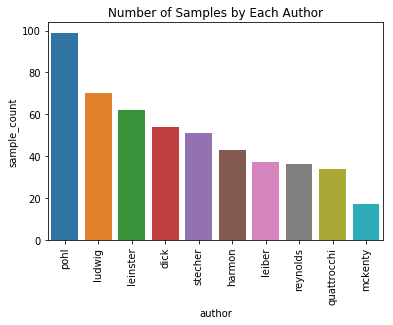

In [10]:
# Look at how many of the samples were written by each author
author_count = df.groupby('author')['text'].count().sort_values(ascending=False).reset_index()
author_count.columns = ['author', 'sample_count']
ax = sns.barplot(x='author', y='sample_count', data=author_count)
plt.xticks(rotation=90)
plt.title('Number of Samples by Each Author')
plt.show()

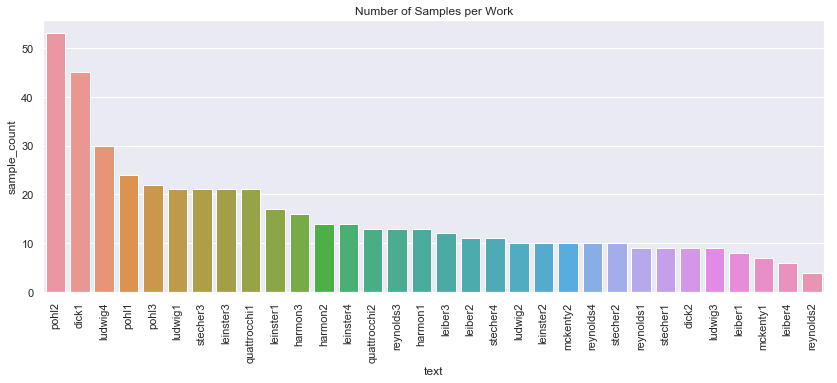

In [11]:
# Look at the number of samples in each work
works_count = df.groupby('text')['author'].count().sort_values(ascending=False).reset_index()
works_count.columns = ['text', 'sample_count']
sns.set(rc={'figure.figsize':(14, 5)})
ax = sns.barplot(x='text', y='sample_count', data=works_count)
plt.title('Number of Samples per Work')
plt.xticks(rotation=90)
plt.show()

In [12]:
# Convert to lemma
both_sents = [' '.join([token.lemma_ for token in sent]) for sent in df['text_sentences']]

# Convert to Part of speech
both_pos = [' '.join([token.pos_ for token in sent]) for sent in df['text_sentences']]


In [58]:
name_list = ['tasso', 'klaus', 'koitska', 'quade', 'hendrick', 'calhoun', 'bates', 'brooks',
             'nordenfeld', 'derek', 'hendricks', 'burckhardt', 'mooney', 'swanson']

ents_list = ['PERSON', 'GPE', 'NORP']


# ['yes' if v == 1 else 'no' if v == 2 else 'idle' for v in l]

# lemma without names
both_no_people = [' '.join([token.lemma_ if ((token.ent_type_ not in ents_list) & 
                                             (token.lemma_ not in name_list)) 
                                         else 'NORP' if token.ent_type_ == 'NORP' for token in sent])
                                         for sent in df['text_sentences']]

SyntaxError: invalid syntax (<ipython-input-58-159090205490>, line 12)

## Bag of Words - not currently used

In [14]:
vectorizer = CountVectorizer(max_features=2500, min_df=5, stop_words=STOP_WORDS)
X = vectorizer.fit_transform(both_sents)
columns = list(vectorizer.get_feature_names())
print('There are {} features'.format(len(columns)))
print(columns[0:20])

# Convert bag of words to a dataframe
df_bow = pd.DataFrame(X.toarray(), columns=columns)

There are 2500 features
['000', '15th', 'abandon', 'ability', 'able', 'aboard', 'abruptly', 'absently', 'absolutely', 'absorb', 'academy', 'acceleration', 'accent', 'accept', 'accident', 'accomplish', 'accord', 'account', 'accuse', 'ache']


In [ ]:
# Only do this one time
#df = df.join(df_bow)

# Parts of Speech

In [15]:
vectorizer_pos = CountVectorizer()
X_pos = vectorizer_pos.fit_transform(both_pos)
columns_pos = list(vectorizer_pos.get_feature_names())
print(columns_pos[0:20])
print(X_pos.toarray())  

df_pos = pd.DataFrame(X_pos.toarray(), columns=columns_pos)

['adj', 'adp', 'adv', 'cconj', 'det', 'intj', 'noun', 'num', 'part', 'pron', 'propn', 'punct', 'sym', 'verb']
[[ 36  43  18 ...  48   0  63]
 [ 56  62  64 ... 261   0 175]
 [ 75 103  70 ... 242   0 187]
 ...
 [ 42  45  34 ...  63   0  75]
 [ 37  35  21 ...  44   0  77]
 [ 59  54  40 ... 118   0 113]]


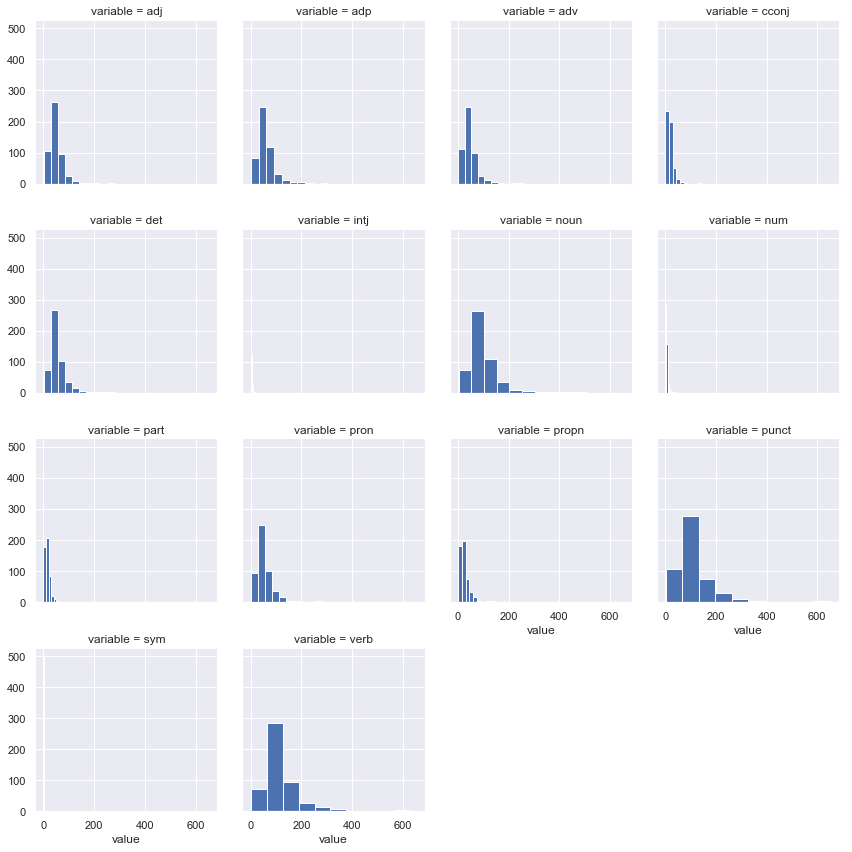

In [16]:
g = sns.FacetGrid(df_pos.melt(), col='variable', col_wrap=4, height=3,)
g.map(plt.hist, 'value')
plt.show()

Verbs, punctuation, and nouns are the most common parts of speech in these articles.  Several of them are rarely used and may not be useful for modeling. 

In [17]:
df.head()

,text_sentences,text,author
0,"(Ed, had, always, been, a, practical, man, ,, ...",dick2,dick
1,"("", Look, at, it, !, "", Loyce, snapped, ., "", ...",dick2,dick
2,"("", Name, ?, "", the, cop, with, the, notebook,...",dick2,dick
3,"(For, a, long, time, Loyce, watched, ,, crouch...",dick2,dick
4,"(Loyce, relaxed, a, little, ., He, studied, th...",dick2,dick


In [18]:
df_pos.head()

,adj,adp,adv,cconj,det,intj,noun,num,part,pron,propn,punct,sym,verb
0,36,43,18,21,46,0,94,3,10,28,9,48,0,63
1,56,62,64,20,73,6,153,2,24,66,50,261,0,175
2,75,103,70,26,120,4,198,5,29,74,43,242,0,187
3,26,55,24,19,51,0,86,1,10,25,14,67,0,80
4,89,84,42,26,85,1,161,4,22,53,19,155,0,128


In [19]:
# Only do join 1x, currently commented out to avoid accidentally repeating
#df = df.join(df_pos)
df.head()

,text_sentences,text,author,adj,adp,adv,cconj,det,intj,noun,num,part,pron,propn,punct,sym,verb
0,"(Ed, had, always, been, a, practical, man, ,, ...",dick2,dick,36,43,18,21,46,0,94,3,10,28,9,48,0,63
1,"("", Look, at, it, !, "", Loyce, snapped, ., "", ...",dick2,dick,56,62,64,20,73,6,153,2,24,66,50,261,0,175
2,"("", Name, ?, "", the, cop, with, the, notebook,...",dick2,dick,75,103,70,26,120,4,198,5,29,74,43,242,0,187
3,"(For, a, long, time, Loyce, watched, ,, crouch...",dick2,dick,26,55,24,19,51,0,86,1,10,25,14,67,0,80
4,"(Loyce, relaxed, a, little, ., He, studied, th...",dick2,dick,89,84,42,26,85,1,161,4,22,53,19,155,0,128


## Additional Counts - Words, everything, all caps

In [20]:
# Add word and punctuation count
df['word_count'] = df['text_sentences'].apply(len)-df['punct']

In [21]:
df['all_count'] = df['text_sentences'].apply(len)
df['all_caps'] = [sum([token.is_upper for token in sent]) for sent in df['text_sentences']]
df['exclamation'] = [sum([token.text == '!' for token in sent]) for sent in df['text_sentences']]
df['quotes'] = [sum([token.text == '"' for token in sent]) for sent in df['text_sentences']]
df['question'] = [sum([token.text == '!' for token in sent]) for sent in df['text_sentences']]

In [22]:
# One column was renamed to pronpos in the join
#new_columns_pos = columns_pos[:9] + columns_pos[10:] + ['pronpos']
#new_columns_pos

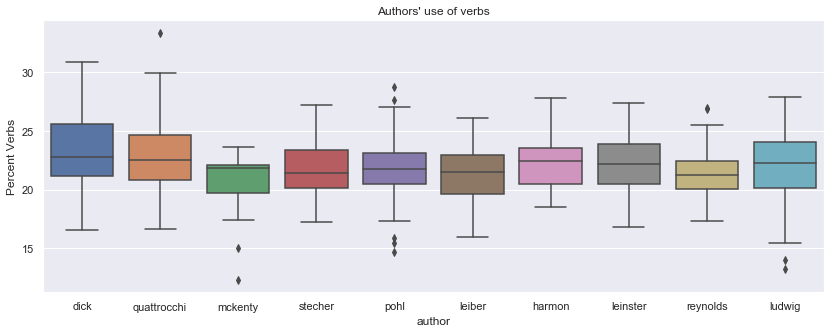

In [23]:
#parts_speech = df.groupby('author')[new_columns_pos].mean()
df['verb_perc'] = df['verb'] / df['word_count'] * 100

plt.title("Authors' use of verbs")
ax = sns.boxplot(x='author', y='verb_perc', data=df)
plt.ylabel('Percent Verbs')
plt.show()

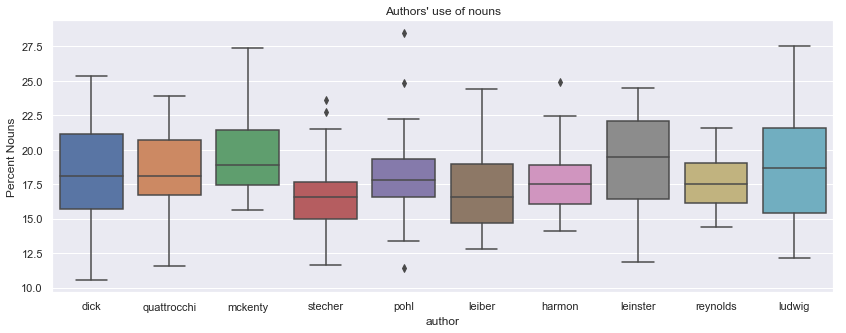

In [24]:
df['noun_perc'] = df['noun'] / df['word_count'] * 100

plt.title("Authors' use of nouns")
ax = sns.boxplot(x='author', y='noun_perc', data=df)
plt.ylabel('Percent Nouns')
plt.show()


## TF- IDF (Term Frequency - Inverse Document Frequency)

Term frequency - inverse document frequency was used to analyze the dataset because the words are given measurement of relevancy, not frequency.  I think this is a more interesting way of analyzing the science fiction short stories. Truncated SVD or singular value decomposition is used to reduce the number of features before clustering.  When truncated SVD is used with TF-IDF this is also called LSA or latent semantic analysis. 

In [25]:
# Split original into train and test, used to look at text later
X_train, X_test, y_train, y_test = train_test_split(both_sents, 
                                                    df['author'], 
                                                    test_size=0.25, 
                                                    random_state=0)

vectorizer_tfidf = TfidfVectorizer(max_df=0.75, # drop words that occur in more than this % of paragraphs
                             min_df=5, # only use words that appear at least 5 times
                             stop_words=STOP_WORDS, 
                             lowercase=True, #convert everything to lower case
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


# Fit and transform training data set, only transform test
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)
X_test_tfidf = vectorizer_tfidf.transform(X_test)

print("Number of features: %d" % X_train_tfidf.get_shape()[1])

#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer_tfidf.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

# This output is long, so suppressed, but interesting for debugging
# Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 
# indicates that the word was present once in that sentence.
# print('Original section:', X_train[1])
# print('Tf_idf vector:', tfidf_bypara[1])

df_tfidf_train = pd.DataFrame(X_train_tfidf.toarray(), columns=list(terms))
df_tfidf_test = pd.DataFrame(X_test_tfidf.toarray(), columns=list(terms))

# This is a little redundant, but used later to join with the full dataframe, could also join 
# the train and test dataframes
df_tfidf = pd.DataFrame(vectorizer_tfidf.transform(both_sents).toarray(), columns=list(terms))

# Reduce number of features
svd = TruncatedSVD(200)
lsa = make_pipeline(svd, Normalizer(copy=False))

# Fit model to training data, transform both training and test
X_train_lsa = lsa.fit_transform(X_train_tfidf)
X_test_lsa = lsa.transform(X_test_tfidf)

variance_explained = svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components: {:.2f}".format(total_variance*100))


Number of features: 2561
Percent variance captured by all components: 80.45


# Clustering the Passages

## Mean Shift

Number of estimated clusters: 4


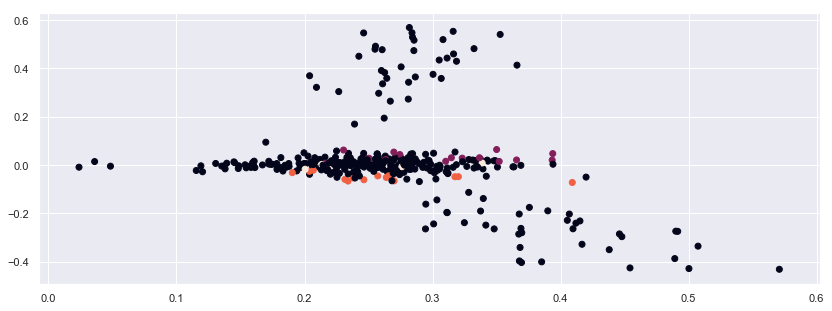

Comparing the assigned categories to the ones in the data:
col_0         0   1   2  3
author                    
dick         42   0   0  0
harmon       31   0   0  0
leiber       28   0   0  0
leinster     40   0   0  7
ludwig       32  18   0  0
mckenty      14   0   0  0
pohl         61   0  14  0
quattrocchi  26   0   0  0
reynolds     28   0   0  0
stecher      36   0   0  0


In [26]:
# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_train_lsa, quantile=0.01)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train_lsa)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

plt.scatter(X_train_lsa[:, 0], X_train_lsa[:,1], c=labels)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train,labels))

## Kmeans, 10 clusters

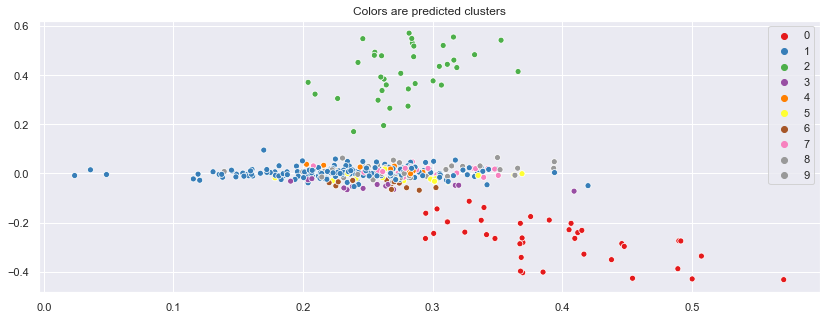

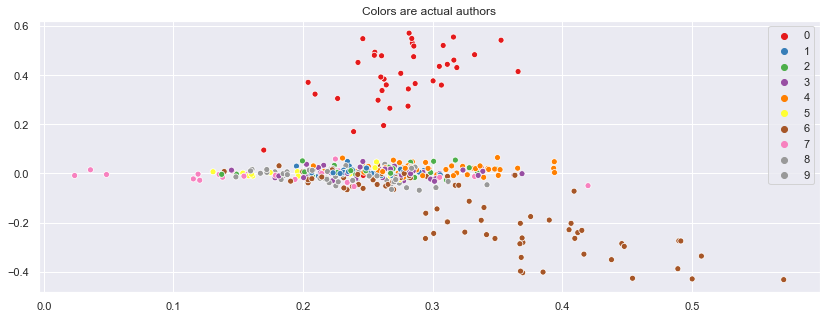

Comparing k-means clusters against the data:
col_0         0   1   2   3   4   5   6   7   8   9
author                                             
dick          0   6  36   0   0   0   0   0   0   0
harmon        0  31   0   0   0   0   0   0   0   0
leiber        0  28   0   0   0   0   0   0   0   0
leinster      0  14   0   0  17  16   0   0   0   0
ludwig        0  11   0   0   0   0   0  20  19   0
mckenty       0  14   0   0   0   0   0   0   0   0
pohl         38   3   0  14   0   0   0   0   0  20
quattrocchi   0  26   0   0   0   0   0   0   0   0
reynolds      0  16   0   0   0   0  12   0   0   0
stecher       0  36   0   0   0   0   0   0   0   0

Adjusted Rand Index: 0.19
Silhouette Score: 0.09
Cluster 0: chandler exec hsi koitska love man body know like rosalie orphalese look
Cluster 1: craig know man time like look charlie good tell ship think come
Cluster 2: hendricks klaus tasso hendrick bunker ash david claws rudi come major variety
Cluster 3: mooney harse pale hote

In [27]:
# Calculate predicted values.
km = KMeans(n_clusters=10)
y_pred = km.fit_predict(X_train_lsa)

# Plot the solution.
sns.scatterplot(X_train_lsa[:, 0], X_train_lsa[:, 1], hue=y_pred, legend='full', palette='Set1')
plt.title('Colors are predicted clusters')
plt.show()

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.fit_transform(y_test)

sns.scatterplot(X_train_lsa[:, 0], X_train_lsa[:, 1], hue=y_train_enc, legend='full', palette='Set1')
plt.title('Colors are actual authors')
plt.show()
# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_train, y_pred))

# Can also pring label encoded values cross tabs to compare with cluster 
# print('\nCrosstab with label encoded values.  Columns are clusters\n')
# print(pd.crosstab(y_train_enc, y_pred))

print('\nAdjusted Rand Index: {:.2f}'.format(metrics.adjusted_rand_score(y_train, y_pred)))
print('Silhouette Score: {:.2f}'.format(metrics.silhouette_score(X_train_lsa, 
                                                                 y_pred, 
                                                                 metric='euclidean')))

# Find the words corresponding to the cluster centroids
original_space_centroids = svd.inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]

terms = vectorizer_tfidf.get_feature_names()
for i in range(10):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :12]:
        print(' %s' % terms[ind], end='')
    print()

# Part of Speech clustering

In [28]:
df_pos.head()

,adj,adp,adv,cconj,det,intj,noun,num,part,pron,propn,punct,sym,verb
0,36,43,18,21,46,0,94,3,10,28,9,48,0,63
1,56,62,64,20,73,6,153,2,24,66,50,261,0,175
2,75,103,70,26,120,4,198,5,29,74,43,242,0,187
3,26,55,24,19,51,0,86,1,10,25,14,67,0,80
4,89,84,42,26,85,1,161,4,22,53,19,155,0,128


In [29]:
df_pos['all_caps'] = df['all_caps']
df_pos['exclamation'] = df['exclamation']
df_pos['question'] = df['question']

In [30]:
# Omit sym, intj, almost no examples of it
# Models perform better using punct than all_caps, exclamation, and question
df_pos_cols = ['adj', 'adp', 'adv', 'cconj', 'det', 'noun', 'punct',
               'num', 'part', 'pron', 'propn', 'verb']

## Means Shift

In [31]:
#Normalize POS data along feature axis to make up for shorter and longer passages
norm = Normalizer(norm='l2')
Xpos_norm = norm.fit_transform(df_pos[df_pos_cols])

X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(Xpos_norm, 
                                                    df['author'], 
                                                    test_size=0.25, 
                                                    random_state=0)

y_train_text, y_test_text = train_test_split(df['text'], test_size=0.25, random_state=0)

Number of estimated clusters: 4


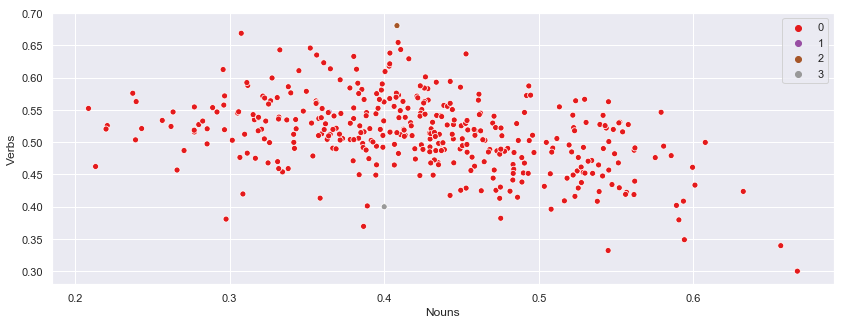

Comparing the assigned categories to the ones in the data:
col_0         0  1  2  3
author                  
dick         42  0  0  0
harmon       31  0  0  0
leiber       28  0  0  0
leinster     47  0  0  0
ludwig       50  0  0  0
mckenty      14  0  0  0
pohl         75  0  0  0
quattrocchi  23  1  1  1
reynolds     28  0  0  0
stecher      36  0  0  0

Adjusted Rand Index: 0.00
Silhouette Score: 0.18


In [32]:
# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_train_pos, quantile=0.2)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train_pos)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

sns.scatterplot(X_train_pos[:, 5], X_train_pos[:,-1], hue=labels, legend='full', palette='Set1')
plt.xlabel('Nouns')
plt.ylabel('Verbs')
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train_pos,labels))
print('\nAdjusted Rand Index: {:.2f}'.format(metrics.adjusted_rand_score(y_train_pos, 
                                                                         labels)))
print('Silhouette Score: {:.2f}'.format(metrics.silhouette_score(X_train_pos, 
                                                                 labels, 
                                                                 metric='euclidean')))

## KMeans

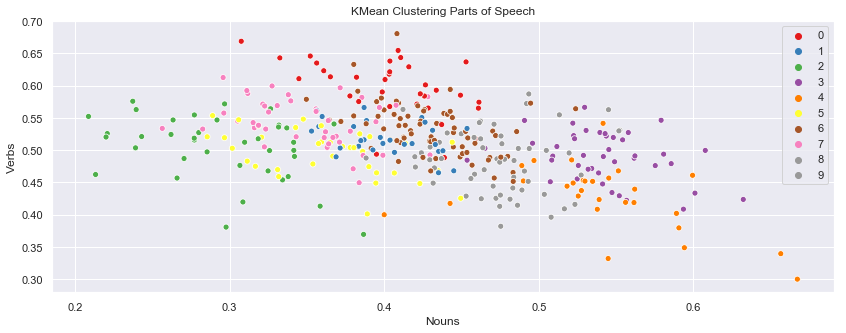

Comparing k-means clusters against the data:
col_0        0   1   2   3  4   5   6   7  8   9
author                                          
dick         0   1  16   2  1   6   2   2  1  11
harmon       8   1   2   3  0   3   4   5  4   1
leiber       7   0   2   2  2   1   3   6  4   1
leinster     7   2   0  16  3   0  10   6  3   0
ludwig       0   2   8   5  5  13   5   3  0   9
mckenty      0   4   0   2  3   0   1   0  2   2
pohl         6   5   1   5  7   4  19  14  5   9
quattrocchi  1   1   7   1  3   1   7   1  0   4
reynolds     0  10   1   2  3   6   5   0  0   1
stecher      5   2   1   4  1   1  14   6  1   1
Adjusted Rand Index: 0.06
Silhouette Score: 0.13


In [33]:
# Calculate predicted values.
y_pred = KMeans(n_clusters=10).fit_predict(X_train_pos)

# Plot the solution.
sns.scatterplot(X_train_pos[:, 5], X_train_pos[:, -1], hue=y_pred, legend='full', palette='Set1')
plt.title('KMean Clustering Parts of Speech')
plt.xlabel('Nouns')
plt.ylabel('Verbs')
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_train_pos, y_pred))
print('Adjusted Rand Index: {:.2f}'.format(metrics.adjusted_rand_score(y_train_pos, 
                                                                       y_pred)))
print('Silhouette Score: {:.2f}'.format(metrics.silhouette_score(X_train_pos, 
                                                                y_pred, 
                                                                metric='euclidean')))


## Spectral

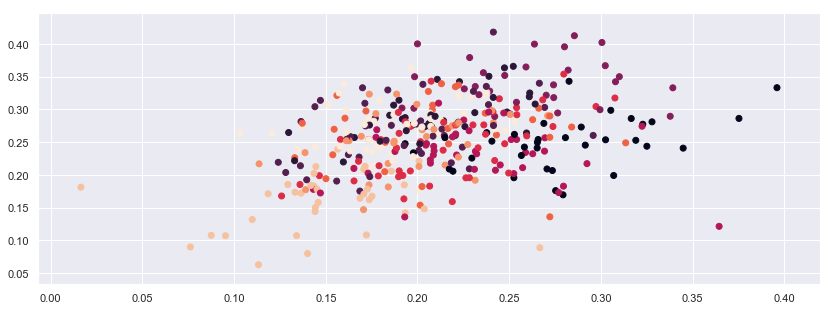

Comparing the assigned categories to the ones in the data:
col_0         0  1   2  3   4   5   6   7   8   9
author                                           
dick          4  0   4  1   6   1   1   1  15   9
harmon        6  8   1  1   0   9   0   1   1   4
leiber        3  8   3  3   3   4   0   0   3   1
leinster      0  6   4  6   5   5  16   2   0   3
ludwig       14  0   2  3   3   5   4  10   7   2
mckenty       1  0   0  3   1   1   2   2   0   4
pohl          1  7  15  6  16  12   3   3   1  11
quattrocchi   2  1   0  1   4   2   2   1   7   6
reynolds      2  0   5  2   2   0   2  11   1   3
stecher       2  3  10  3   2   6   0   1   1   8
Adjusted Rand Index: 0.06
Silhouette Score: 0.07


In [34]:
n_clusters = 10

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters)
sc.fit(X_train_pos)

#Predicted clusters.
predict=sc.fit_predict(X_train_pos)

#Graph results.
plt.scatter(X_train_pos[:, 0], X_train_pos[:, 1], c=predict)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train_pos, predict))
print('Adjusted Rand Index: {:.2f}'.format(metrics.adjusted_rand_score(y_train_pos, 
                                                                       predict)))
print('Silhouette Score: {:.2f}'.format(metrics.silhouette_score(X_train_pos, 
                                                                predict, 
                                                                metric='euclidean')))


# Part of Speech and TFIDF

In [35]:
df_tfidf_pos = df.join(df_tfidf, lsuffix='df', rsuffix='tfidf')
df_tfidf_pos.head()

,text_sentences,text,author,adj,adp,adv,cconj,det,intj,noun,...,yawn,yeah,year,yell,yellow,yes,yesterday,york,young,youth
0,"(Ed, had, always, been, a, practical, man, ,, ...",dick2,dick,36,43,18,21,46,0,94,...,0.0,0.0,0.042665,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
1,"("", Look, at, it, !, "", Loyce, snapped, ., "", ...",dick2,dick,56,62,64,20,73,6,153,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
2,"("", Name, ?, "", the, cop, with, the, notebook,...",dick2,dick,75,103,70,26,120,4,198,...,0.0,0.0,0.018716,0.0,0.034977,0.0,0.0,0.0,0.000000,0.0
3,"(For, a, long, time, Loyce, watched, ,, crouch...",dick2,dick,26,55,24,19,51,0,86,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
4,"(Loyce, relaxed, a, little, ., He, studied, th...",dick2,dick,89,84,42,26,85,1,161,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.030448,0.0


In [36]:
print(df_tfidf_pos.shape)
print(df_tfidf_pos.columns)

(503, 2586)
Index(['text_sentences', 'text', 'author', 'adj', 'adp', 'adv', 'cconj', 'det',
       'intj', 'noun',
       ...
       'yawn', 'yeah', 'year', 'yell', 'yellow', 'yes', 'yesterday', 'york',
       'young', 'youth'],
      dtype='object', length=2586)


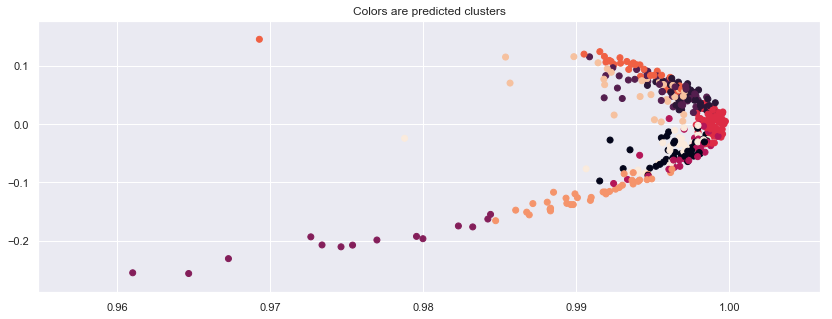

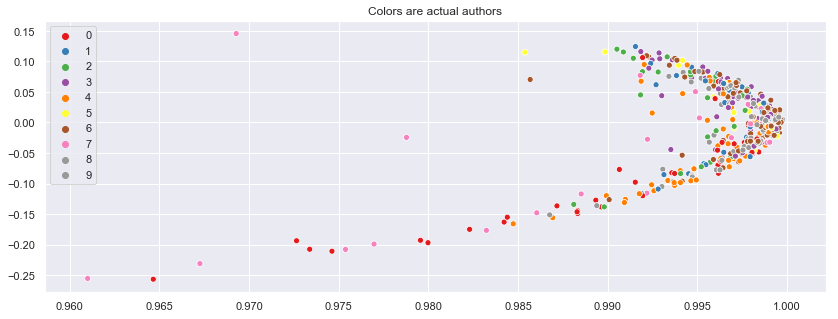

Comparing k-means clusters against the data:
col_0         0   1   2  3   4   5  6   7  8   9
author                                          
dick          3   3   0  9   2   0  2  10  2  11
harmon        4   4   9  0   2   3  3   3  0   3
leiber        6   1  13  0   0   0  2   2  2   2
leinster      6  13   6  0   2   9  8   0  3   0
ludwig        4   3   0  0   9   6  2  12  8   6
mckenty       0   2   1  0   2   4  1   0  4   0
pohl         11   8   7  0   4  27  9   2  3   4
quattrocchi   2   1   1  5   0   5  1   3  3   5
reynolds      0   1   0  0  12   7  3   3  1   1
stecher       6   5   7  0   1  12  1   2  1   1

Crosstab with label encoded values.  Columns are clusters

col_0   0   1   2  3   4   5  6   7  8   9
row_0                                     
0       3   3   0  9   2   0  2  10  2  11
1       4   4   9  0   2   3  3   3  0   3
2       6   1  13  0   0   0  2   2  2   2
3       6  13   6  0   2   9  8   0  3   0
4       4   3   0  0   9   6  2  12  8   6
5     

In [37]:
df_tfidf_pos_train = df_tfidf_pos.drop(['all_count', 'text_sentences', 'text', 'author', 'noun_perc', 
                        'verb_perc', 'exclamation', 'questiondf', 'all_caps', 'sym', 'intj'], axis=1)

X_train_tf_pos, X_test_tf_pos, y_train_tf_pos, y_test_tf_pos = train_test_split(df_tfidf_pos_train, 
                                                                                df['author'], 
                                                                                test_size=0.25, 
                                                                                random_state=0)

#Our SVD data reducer.  We are going to reduce the feature space.
svd= TruncatedSVD(150)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa_tf_pos = lsa.fit_transform(X_train_tf_pos)
X_test_lsa_tf_pos = lsa.transform(X_test_tf_pos)


# Calculate predicted values.
y_pred2 = KMeans(n_clusters=10).fit_predict(X_train_lsa_tf_pos)

# Plot the solution.
plt.scatter(X_train_lsa_tf_pos[:, 0], X_train_lsa_tf_pos[:, 1], c=y_pred2)
plt.title('Colors are predicted clusters')
plt.show()

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_tf_pos)
y_test_enc = le.fit_transform(y_test_tf_pos)

sns.scatterplot(X_train_lsa_tf_pos[:, 0], X_train_lsa_tf_pos[:, 1], hue=y_train_enc, legend='full', palette='Set1')
plt.title('Colors are actual authors')
plt.show()
# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_train_tf_pos, y_pred2))
print('\nCrosstab with label encoded values.  Columns are clusters\n')
print(pd.crosstab(y_train_enc, y_pred2))
print('Adjusted Rand Index: {:.2f}'.format(metrics.adjusted_rand_score(y_train_tf_pos, 
                                                                       y_pred2)))
print('Silhouette Score: {:.2f}'.format(metrics.silhouette_score(X_train_tf_pos, 
                                                                y_pred2, 
                                                                metric='euclidean')))

# TFIDF - no names included

In [51]:
X_train_no_name, X_test_no_name, y_train_no_name, y_test_no_name = train_test_split(both_no_people, 
                                                                                    df['author'], 
                                                                                    test_size=0.25, 
                                                                                    random_state=0)

vect_tfidf_no_name = TfidfVectorizer(max_df=0.25, # drop words that occur in more than this % of paragraphs
                                     min_df=5, # only use words that appear at least 5 times
                                     stop_words=STOP_WORDS, 
                                     lowercase=True, #convert everything to lower case
                                     use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                                     norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                                     smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                                    )


#Applying the vectorizer, fit only on training
X_train_tfidf_no_name = vect_tfidf_no_name.fit_transform(X_train_no_name)
X_test_tfidf_no_name = vect_tfidf_no_name.transform(X_test_no_name)

print("Number of features: %d" % X_train_tfidf_no_name.get_shape()[1])


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr2 = X_train_tfidf_no_name.tocsr()

#number of paragraphs
n = X_train_tfidf_csr2.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
no_name_terms = vect_tfidf_no_name.get_feature_names()

#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr2.nonzero()):
    tfidf_bypara[i][no_name_terms[j]] = X_train_tfidf_csr2[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
#print('Original sentence:', X_train[1])
#print('Tf_idf vector:', tfidf_bypara[1])

df_train_tfidf_no_name = pd.DataFrame(X_train_tfidf_no_name.toarray(), columns=list(no_name_terms))
df_test_tfidf_no_name = pd.DataFrame(X_test_tfidf_no_name.toarray(), columns=list(no_name_terms))

#Our SVD data reducer.  We are going to reduce the feature space.
svd2 = TruncatedSVD(200)
lsa = make_pipeline(svd2, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.

X_train_lsa_no_name = lsa.fit_transform(X_train_tfidf_no_name)
X_test_lsa_no_name = lsa.transform(X_test_tfidf_no_name)

variance_explained = svd2.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components: {:.2f}".format(total_variance*100))

Number of features: 2394
Percent variance captured by all components: 75.60


In [52]:
def k_means(n_cluster, Xtrain, ytrain, draw=False, terms=no_name_terms):
    # Calculate predicted values.
    km = KMeans(n_clusters=n_cluster)
    y_pred = km.fit_predict(Xtrain)

    if draw == True:
        # Plot the solution.
        plt.scatter(Xtrain[:, 0], Xtrain[:, 1], c=y_pred)
        plt.title('Colors are predicted clusters')
        plt.show()

    le = LabelEncoder()
    y_train_enc = le.fit_transform(ytrain)
   
    silhouette_score = metrics.silhouette_score(Xtrain, y_pred, metric='euclidean')
    ari_score = metrics.adjusted_rand_score(ytrain, y_pred)
            
    if draw == True:
        sns.scatterplot(Xtrain[:, 0], Xtrain[:, 1], hue=y_train_enc, legend='full', palette='Set1')
        plt.title('Colors are actual authors')
        plt.show()
        # Check the solution against the data.
        print('Comparing k-means clusters against the data:')
        print(pd.crosstab(ytrain, y_pred))
        print('\nCrosstab with label encoded values.  Columns are clusters\n')
        print(pd.crosstab(y_train_enc, y_pred))
        print('Adjusted Rand Index: {:.2f}'.format(ari_score))
        print('Silhouette Score: {:.2f}'.format(silhouette_score))
        
        # Need to update svd2 if used with a different model
        original_space_centroids = svd2.inverse_transform(km.cluster_centers_)
        order_centroids = original_space_centroids.argsort()[:, ::-1]

        for i in range(n_cluster):
            print("Cluster %d:" % i, end='')
            for ind in order_centroids[i, :12]:
                print(' %s' % terms[ind], end='')
            print()
        
    return ari_score, silhouette_score


In [53]:
scores = []

# Cross validation for printing number of clusters
for cluster in range(2, 11):
    ari = []
    sil = []
    # Average scores over 5 models, cross-validate
    for i in range(1, 6):
        ari_new, sil_new = k_means(cluster, X_train_lsa_no_name, ytrain=y_train_no_name, draw=False)
        ari.append(ari_new)
        sil.append(sil_new)
    ari_all = (np.mean(ari), np.std(ari))
    sil_all = (np.mean(sil), np.std(sil))
    scores.append((ari_all, sil_all, cluster))

scores.sort(reverse=True)

In [54]:
for score in scores[:5]:
    print(score)

((0.2534890191814423, 0.020109201325133393), (0.030746472772466515, 0.001985069549479306), 8)
((0.2322514814317244, 0.031556962724285396), (0.039687239294876164, 0.001623449443628049), 10)
((0.23155453219615482, 0.0416055641467361), (0.02562847728537959, 0.0020289974536376065), 6)
((0.22019035221755828, 0.033520983250626794), (0.028018046233996695, 0.002206417537319218), 7)
((0.20526519170367186, 0.059148848590656576), (0.03475943047907634, 0.0021730102150853956), 9)


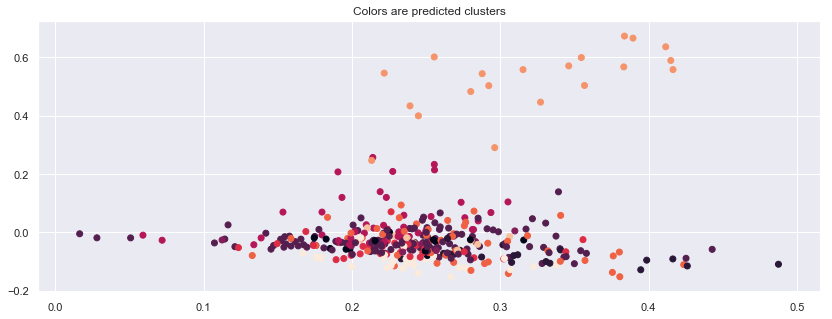

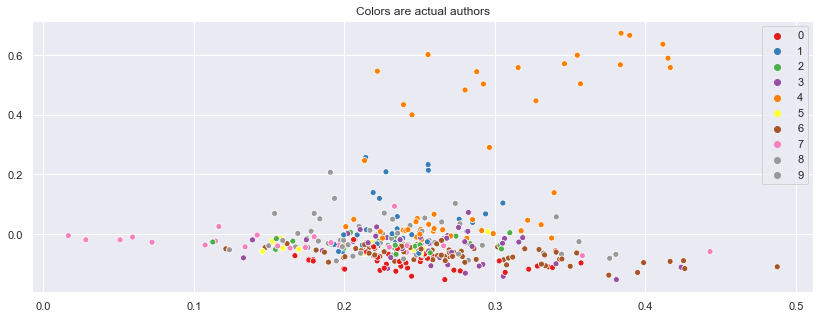

Comparing k-means clusters against the data:
col_0        0   1   2  3   4   5   6   7   8   9
author                                           
dick         1   0   5  0   0   0   3   0   0  33
harmon       5   0   4  0  21   0   1   0   0   0
leiber       0   0  17  9   1   0   1   0   0   0
leinster     7   0   3  0   4   0  21   0  12   0
ludwig       0   0  30  0   0   0   0  20   0   0
mckenty      0   0  14  0   0   0   0   0   0   0
pohl         0  21  42  0   1   9   2   0   0   0
quattrocchi  0   0  17  0   5   3   1   0   0   0
reynolds     0   0   0  0   1  18   9   0   0   0
stecher      2   0   8  0  11   3  12   0   0   0

Crosstab with label encoded values.  Columns are clusters

col_0  0   1   2  3   4   5   6   7   8   9
row_0                                      
0      1   0   5  0   0   0   3   0   0  33
1      5   0   4  0  21   0   1   0   0   0
2      0   0  17  9   1   0   1   0   0   0
3      7   0   3  0   4   0  21   0  12   0
4      0   0  30  0   0   0   0

(0.2135142992091093, 0.036538541657711046)

In [55]:
k_means(10, X_train_lsa_no_name, ytrain=y_train_no_name, draw=True)

# Classifiers

## TFIDF, random forest

In [ ]:
rfc = RandomForestClassifier(n_estimators=500)

train = rfc.fit(X_train_tfidf, y_train)

print('Training set score:', rfc.score(X_train_tfidf, y_train))
print('\nTest set score:', rfc.score(X_test_tfidf, y_test))

## TFIDF, logistic regression

In [ ]:
lr = LogisticRegression(solver='lbfgs', multi_class='ovr', C=1000)
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
train = lr.fit(X_train_lsa, y_train_enc)

y_pred_lsa = lr.predict(X_test_lsa)

print('Training set score:', lr.score(X_train_lsa, y_train_enc))
print('\nTest set score:', lr.score(X_test_lsa, y_test_enc))

plt.scatter(y_pred_lsa, y_test_enc)
plt.show()

In [ ]:
# Look at text instead of author, see if we can predict that
y_train_text, y_test_text = train_test_split(df['text'], test_size=0.25, random_state=0)

le_text = LabelEncoder()
y_train_enc_text = le_text.fit_transform(y_train_text)
y_test_enc_text = le_text.transform(y_test_text)


lr_text = LogisticRegression(solver='lbfgs', multi_class='ovr', C=100)
train = lr_text.fit(X_train_lsa, y_train_enc_text)
y_pred_lsa = lr_text.predict(X_test_lsa)

print('Training set score:', lr_text.score(X_train_lsa, y_train_enc_text))
print('\nTest set score:', lr_text.score(X_test_lsa, y_test_enc_text))

plt.scatter(y_pred_lsa, y_test_enc_text)
plt.xlabel('Predicted Text')
plt.ylabel('Actual Text')
plt.plot()

# Look at which texts are not being predicted correctly
print('predicted text, actual text')
for i in range(len(y_pred_lsa)):
    predicted = y_pred_lsa[i]
    actual = y_test_enc_text[i]
    if predicted != actual:
        try:
            print('{} - {}'.format(list(le_text.inverse_transform([predicted]))[0], 
                               list(le_text.inverse_transform([actual]))[0]))
        except:
            print('Transform issue')

## Part of speech - logistic regression

In [ ]:
lr = LogisticRegression(solver='lbfgs', multi_class='ovr')
y_train_enc = le.fit_transform(y_train_pos)
y_test_enc = le.transform(y_test_pos)

train = lr.fit(X_train_pos, y_train_enc)

y_pred_pos_train = lr.predict(X_train_pos)
y_pred_pos = lr.predict(X_test_pos)

print('Training set score: {:.2f}'.format(lr.score(X_train_pos, y_train_enc)))
print('\nTest set score: {:.2f}'.format(lr.score(X_test_pos, y_test_enc)))

plt.scatter(y_pred_pos_train, y_train_enc)
plt.show()

## TF-IDF No names

In [ ]:
lr = LogisticRegression(solver='lbfgs', multi_class='ovr', C=1000)

train = lr.fit(X_train_lsa_no_name, y_train_enc)

y_pred_tf_no_names_train = lr.predict(X_train_lsa_no_name)
y_pred_tf_no_names = lr.predict(X_test_lsa_no_name)

print('Training set score: {:.2f}'.format(lr.score(X_train_lsa_no_name, y_train_enc)))
print('\nTest set score: {:.2f}'.format(lr.score(X_test_lsa_no_name, y_test_enc)))

plt.scatter(y_pred_tf_no_names, y_test_enc)
plt.xlabel('Predicted Text')
plt.ylabel('Actual Text')
plt.show()

# Look at which texts are not being predicted correctly
print('predicted text, actual text')
for i in range(len(y_pred_tf_no_names)):
    predicted = y_pred_tf_no_names[i]
    actual = y_test_enc[i]
    if predicted != actual:
        try:
            print('{} - {}'.format(list(le.inverse_transform([predicted]))[0], 
                               list(le.inverse_transform([actual]))[0]))
        except:
            print('Transform issue')

# Random Forest Classifier

In [ ]:
rfc = RandomForestClassifier(n_estimators=500)

train = rfc.fit(X_train_lsa_no_name, y_train_no_name)

print('Training set score: {:.2f}'.format(rfc.score(X_train_lsa_no_name, y_train_no_name)))
print('\nTest set score: {:.2f}'.format(rfc.score(X_test_lsa_no_name, y_test_no_name)))

# Feature importances
Attempt at mapping feature importance back to words. Used abs vlue of svd.components_

In [ ]:
# Questionable
# Should it be absolute values of svd components or not?
# 
svd_indices = np.argsort(abs(svd2.components_))
words = list(df_train_tfidf_no_name.columns)

features = []
for index in svd_indices:
    feature = []
    # This range is how many words I want
    for i in range(5):
        for counter, value in enumerate(index):
            if value == i:
                feature.append(words[counter])
    features.append(feature)

# Back to tfidf
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

terms = vect_tfidf_no_name.get_feature_names()

for f in range(10):
    print('{}. feature {} ({:.4f}) {}'.format((f+1), indices[f], importances[indices[f]], features[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(0,20), importances[indices][:20], color="r", align="center")
plt.xticks(range(20), indices)
plt.xlim([-1, 20])
plt.show()


In [ ]:
svd2.components_

# Random Forest Classifier, no TruncatedSVD
This will let me see which words are considered important for classifying the selections and compare them to the words used for clustering.

In [ ]:
rfc = RandomForestClassifier(n_estimators=500)

train = rfc.fit(X_train_tfidf_no_name, y_train_no_name)

print('Training set score:', rfc.score(X_train_tfidf_no_name, y_train_no_name))
print('\nTest set score:', rfc.score(X_test_tfidf_no_name, y_test_no_name))

In [ ]:
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

terms = vect_tfidf_no_name.get_feature_names()

for f in range(20):
    print('{}. feature {} ({:.4f}) {}'.format((f+1), indices[f], importances[indices[f]], terms[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(0,20), importances[indices][:20], color="r", align="center")
plt.xticks(range(20), indices, rotation=90)
plt.xlim([-1, 20])
plt.show()


# See if model can predict new text

In [ ]:
# This opens the files and cleans them.  It can take a while to run.

path = 'test_file/'
path_clean = 'test_file_cleaned/'

# Change this to False if the files have already been cleaned
clean_file = True

sentences_test = clean_files(path, path_clean, clean_file)


In [ ]:
df['text_sentences'][:5]

In [ ]:
# Convert into a pandas data frame
df_harmon_test = pd.DataFrame(sentences_test)
df_harmon_test.columns = ['text_sentences', 'text', 'author']
print(df_harmon_test.shape)

# lemma without names
harmon_no_people = [' '. join([token.lemma_ for token in sent if token.ent_type_ != 'PERSON'])
                             for sent in df_harmon_test['text_sentences']]

In [ ]:
lr = LogisticRegression(solver='lbfgs', multi_class='ovr', C=1000)

train = lr.fit(X_train_lsa_no_name, y_train_enc)

harmon_tfidf = vect_tfidf_no_name.transform(harmon_no_people)
X_harmon_lsa = lsa.transform(harmon_tfidf.toarray())

y_pred_harmon = lr.predict(X_harmon_lsa)

print(y_pred_harmon)
print(list(le.inverse_transform(y_pred_harmon)))



print(y_pred_harmon, y_test_harmon)

In [ ]:
# Predicted test, run lr from text
y_pred_text_harmon = lr_text.predict(X_harmon_lsa)
print(list(le_text.inverse_transform(y_pred_text_harmon)))


In [ ]:
y_pred_harmon = rfc.predict(harmon_tfidf)

print(list((y_pred_harmon)))

Both logistic regression and random forest failed to predict the correct author of this additional work by Harmon. This could meant that the topic of the story is more similar to one by pohl than the other works by Harmon.  Pohl2 and Harmon4 are both about mind control and killing or being unable to kill people as a result.  I can see how this text could be missclassified as one by Pohl.

# Future Work
It would be interesting to compare these 1950's and 1960's short stories to modern science fiction short stories.  Breaking them down by Parts of Speech did not help with the modeling within this dataset, but perhaps when compared to modern literature it would show a difference.  Another possibility would be to compare them to literature from a different genre.  Could the science fiction works be correctly classified as science fiction?  <br>

Another direction this could be taken would be to break down the works in a different way.  For this analysis I used thought breaks.  They could also be modeled by sentence or as entire works.  By sentence there would be a lot more samples to select from, but less in each sample and so potentially harder to accurately predict the authors.  <br>

This model could also be refined by customizing Spacy to detect a few missed character names.  For example, Hendrick and Derek still appears in the important features of the random forest model.  These are likely missed names.  
